In [1]:
%cd ..

/home/oleg


In [2]:
# type: ignore

import typing
from typing import Any, cast

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import pandas as pd

from asr_eval.streaming.sender import StreamingAudioSender, BaseStreamingAudioSender
from asr_eval.streaming.caller import transсribe_parallel
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import TranscriptionChunk, Signal, OutputChunk
from asr_eval.streaming.evaluation import get_word_timings, get_partial_alignments, partial_alignment_diagram, visualize_history

In [3]:
# type: ignore

dataset: Dataset = load_dataset('bond005/podlodka_speech')['test'].take(4)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
df = pd.DataFrame(list(dataset))

def get_streaming_sender(id: str, audio: dict[str, Any]) -> dict[str, Any]:
    return StreamingAudioSender(
        id=id,
        audio=np.int16(audio['array'] * 32768).tobytes(),
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        densify=True,
        verbose=True,
    )

df['id'] = df.audio.apply(lambda audio: audio['path'])
df['sender'] = df.apply(lambda row: get_streaming_sender(row.id, row.audio), axis=1)

In [4]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()
results = transсribe_parallel(asr=asr, senders=df.sender, n_threads=2)
asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10


LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/phones/word_boundary.int
LOG (VoskAPI:ReadDataFiles():model.cc:315) Loading subtract G.fst model from /home/oleg

Transcribing sound_test_0001.wav
Transcribing sound_test_0002.wav
waited for 0.200 of 0.200 sec (full delay)
Sending: id=sound_test_0001.wav, real 0.000..0.200, audio 0.200..0.200
waited for 0.200 of 0.200 sec (full delay)
Sending: id=sound_test_0002.wav, real 0.000..0.200, audio 0.200..0.200
waited for 0.000 of 0.200 sec (woken up early by consumer)
Sending: id=sound_test_0002.wav, real 0.200..0.400, audio 0.400..0.400
waited for 0.000 of 0.199 sec (woken up early by consumer)
Sending: id=sound_test_0001.wav, real 0.200..0.400, audio 0.400..0.400
waited for 0.000 of 0.200 sec (woken up early by consumer)
Sending: id=sound_test_0002.wav, real 0.400..0.600, audio 0.600..0.600
waited for 0.000 of 0.200 sec (woken up early by consumer)
Sending: id=sound_test_0002.wav, real 0.600..0.800, audio 0.800..0.800
waited for 0.000 of 0.200 sec (woken up early by consumer)
Sending: id=sound_test_0002.wav, real 0.800..1.000, audio 1.000..1.000
waited for 0.000 of 0.200 sec (woken up early by consume

In [5]:
# type: ignore

df['preds'] = [TranscriptionChunk.join(x) for x in results.values()]

jiwer.wer(reference=df['transcription'].tolist(), hypothesis=df['preds'].tolist())

0.5746268656716418

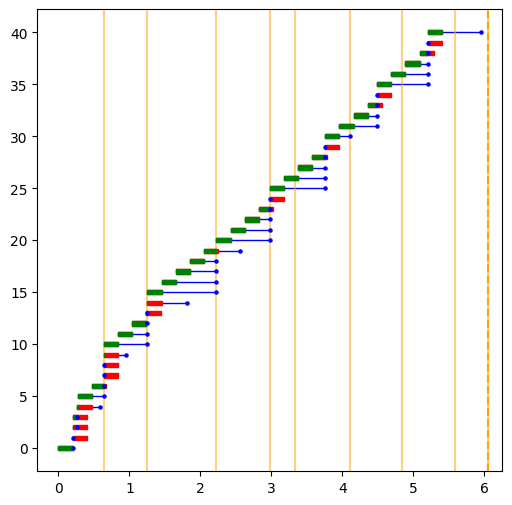

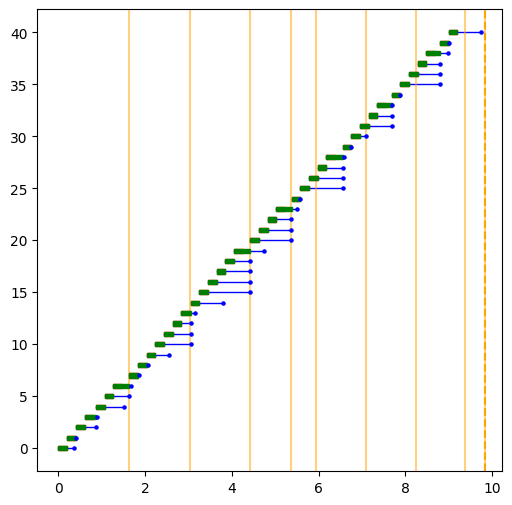

In [6]:
import copy    
    
sample = df.iloc[0] # type: ignore
sender = cast(StreamingAudioSender, sample.sender) # type: ignore
input_chunks = sender.history
timings_history = sender.timings_history
output_chunks = results[sample['id']]

visualize_history(input_chunks, timings_history, output_chunks)

input_chunks = copy.deepcopy(input_chunks)
timings_history = copy.deepcopy(timings_history)
output_chunks = copy.deepcopy(output_chunks)

for chunk in input_chunks + output_chunks:
    chunk.get_timestamp = sender.undensify(cast(float, chunk.get_timestamp))
    chunk.put_timestamp = sender.undensify(cast(float, chunk.put_timestamp))

for delay_info in timings_history:
    delay_info.wait_start_time = sender.undensify(delay_info.wait_start_time)
    delay_info.wait_end_time = sender.undensify(delay_info.wait_end_time)

visualize_history(input_chunks, timings_history, output_chunks)

OutputChunk(data=TranscriptionChunk(uid='988287a7-cddd-4193-9bbb-b196411a383e', text=''), seconds_processed=2.0, put_timestamp=1750009019.8038912, get_timestamp=1750009019.8040373)

In [6]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [8]:
# type: ignore
sample = df.iloc[3]

text = sample['transcription']
text = text.lower().replace('ё', 'е').replace('-', ' ')
for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
    text = text.replace(char, '')

word_timings = get_word_timings(gigaam_model, sample['audio']['array'], text)

sender = cast(StreamingAudioSender, sample.sender)
input_chunks = sender.history
output_chunks = results[sample['id']]

display(input_chunks[:5])
display(output_chunks[:5])

[InputChunk(data=b'', start_time=0.0, end_time=0.6000000000000001, put_timestamp=1749569915.4321923, get_timestamp=1749569918.243591),
 InputChunk(data=b'', start_time=0.6000000000000001, end_time=1.2000000000000002, put_timestamp=1749569915.632271, get_timestamp=1749569918.7008164),
 InputChunk(data=b'', start_time=1.2000000000000002, end_time=1.8000000000000003, put_timestamp=1749569915.832441, get_timestamp=1749569918.7715707),
 InputChunk(data=b'', start_time=1.8000000000000003, end_time=2.4000000000000004, put_timestamp=1749569916.0326502, get_timestamp=1749569919.1953328),
 InputChunk(data=b'', start_time=2.4000000000000004, end_time=3.0000000000000004, put_timestamp=1749569916.232861, get_timestamp=1749569919.9029248)]

[OutputChunk(data=TranscriptionChunk(uid='f45dd85e-13e3-4267-8bc0-b38a74e3227a', text=''), seconds_processed=1.2000000000000002, put_timestamp=1749569918.7714806, get_timestamp=1749569918.7716584),
 OutputChunk(data=TranscriptionChunk(uid='f45dd85e-13e3-4267-8bc0-b38a74e3227a', text=''), seconds_processed=2.4000000000000004, put_timestamp=1749569919.5402348, get_timestamp=1749569919.5404024),
 OutputChunk(data=TranscriptionChunk(uid='f45dd85e-13e3-4267-8bc0-b38a74e3227a', text='да это отсутствие'), seconds_processed=3.0000000000000004, put_timestamp=1749569920.301947, get_timestamp=1749569920.3021364),
 OutputChunk(data=TranscriptionChunk(uid='f45dd85e-13e3-4267-8bc0-b38a74e3227a', text='да это отсутствие долго живущие бранчей'), seconds_processed=4.200000000000001, put_timestamp=1749569921.3353148, get_timestamp=1749569921.335499),
 OutputChunk(data=TranscriptionChunk(uid='f45dd85e-13e3-4267-8bc0-b38a74e3227a', text='да это отсутствие долго живущие бранчей другими словами открой'), se

In [9]:
partial_alignments = get_partial_alignments(input_chunks, output_chunks, word_timings, processes=1) # type: ignore
partial_alignments[:5]

[PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), ), (Token(это, 3-6), ), (Token(отсутствие, 7-17), )], total_true_len=3, score=AlignmentScore(n_word_errors=3, n_correct=0, n_char_errors=15)), audio_seconds_sent=10.200000000000001, audio_seconds_processed=1.2000000000000002, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), ), (Token(это, 3-6), ), (Token(отсутствие, 7-17), ), (Token(долго, 18-23), ), (Token(живущих, 24-31), ), (Token(бранчей, 32-39), )], total_true_len=6, score=AlignmentScore(n_word_errors=6, n_correct=0, n_char_errors=34)), audio_seconds_sent=12.600000000000001, audio_seconds_processed=2.4000000000000004, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), Token(да, 0-2)), (Token(это, 3-6), Token(это, 3-6)), (Token(отсутствие, 7-17), Token(отсутствие, 7-17)), (Token(долго, 18-23), ), (Token(живущих, 24-31), ), (Token(бранчей, 32-39), ), (Token(другими, 40-47), )], total_t

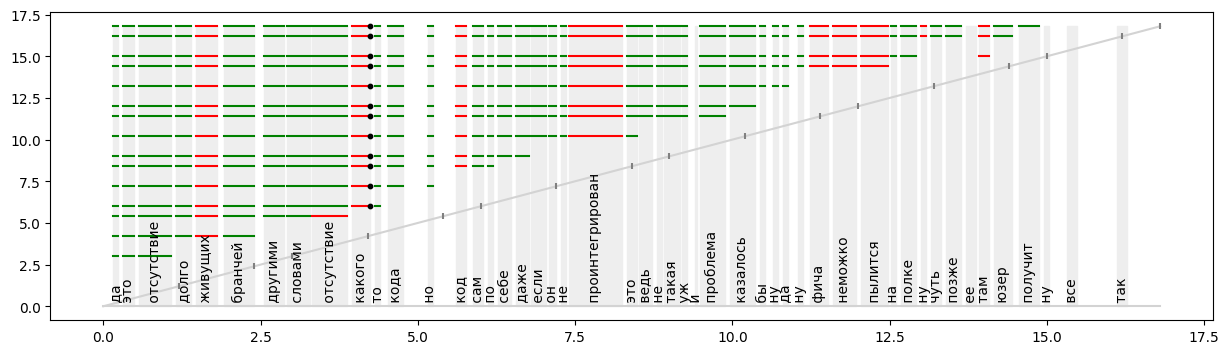

In [17]:
assert input_chunks[-1].end_time is not None

partial_alignment_diagram(
    partial_alignments,
    word_timings,
    audio_len=input_chunks[-1].end_time,  # TODO: may be not precise
    figsize=(15, 4),
    y_type='processed',
)

In [ ]:
# print('Final transcription:', TranscriptionChunk.join(output_chunks))

# true_token_id_to_time_span = {
#     token.id: (start, end) for token, start, end in word_timings
# }

# last_word_end = [
#     max([
#         true_token_id_to_time_span[m.true[-1].id][-1]
#         for m in partial_al.alignment.matches
#         if m.status not in ('deletion', 'insertion')
#     ] or [0])
#     for partial_al in partial_alignments
# ]

# latency_sent = [p.audio_seconds_sent - end for p, end in zip(partial_alignments, last_word_end)]
# print(f'Average latency (sent): {np.mean(latency_sent):.1f} sec')

# latency_processed = [p.audio_seconds_processed - end for p, end in zip(partial_alignments, last_word_end)] # type: ignore
# print(f'Average latency (processed): {np.mean(latency_processed):.1f} sec') # type: ignore

Final transcription: да это отсутствие долго живущие бранчей другими словами отсутствие какому-то кода но кот сам по себе даже если он не проинтегрированы это ведь не такая уж проблема казалось бы ну да ну ещё немножко пылиться на полке но чуть позже этом юзер получит
Average latency (sent): 8.7 sec
Average latency (processed): 1.8 sec
